In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2023-10-21 21:48:19--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv.3’

housing.csv.3       100%[===================>]   1.36M  3.15MB/s    in 0.4s    

2023-10-21 21:48:20 (3.15 MB/s) - ‘housing.csv.3’ saved [1423529/1423529]



In [97]:
df= pd.read_csv('housing.csv.3')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [98]:
df=df[(df["ocean_proximity"] == '<1H OCEAN' ) | (df["ocean_proximity"] ==  'INLAND')]
df["ocean_proximity"] = df["ocean_proximity"].str.lower().str.replace(" ","_").str.replace("<","_")
df = df.reset_index(drop=True)

In [99]:
df["total_bedrooms"]=df["total_bedrooms"].fillna(0)
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [100]:
df["house_logged_value"]=np.log1p(df["median_house_value"])
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,house_logged_value
0,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0,_1h_ocean,12.973866
1,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0,_1h_ocean,12.287657
2,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0,_1h_ocean,12.419574
3,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0,_1h_ocean,12.554971
4,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0,_1h_ocean,12.287196
...,...,...,...,...,...,...,...,...,...,...,...
15682,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,inland,11.265758
15683,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,inland,11.252872
15684,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,inland,11.432810
15685,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,inland,11.346883


In [101]:
del df["median_house_value"]

In [102]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'house_logged_value'],
      dtype='object')

In [103]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df,test_size=0.2,random_state=1)
df_train,df_val =train_test_split(df_full_train,test_size=0.25,random_state=1)
print(len(df_train),len(df_val),len(df_test))

9411 3138 3138


In [104]:
y_train = df_train["house_logged_value"]
y_full_train = df_full_train["house_logged_value"]
y_val = df_val["house_logged_value"]
y_test =df_test["house_logged_value"]

del df_train["house_logged_value"]
del df_full_train["house_logged_value"]
del df_val["house_logged_value"]
del df_test["house_logged_value"]

In [61]:
df_train.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [105]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=True)
encoded_df_train = dv.fit_transform(df_train.to_dict(orient='records'))
encoded_df_val = dv.transform(df_val.to_dict(orient='records'))
encoded_df_train

<9411x10 sparse matrix of type '<class 'numpy.float64'>'
	with 84699 stored elements in Compressed Sparse Row format>

In [75]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(encoded_df_train,y_train)

DecisionTreeRegressor(max_depth=1)

In [76]:
splitting_feature = dv.feature_names_[dt.tree_.feature[0]]
print("The feature used for splitting the data is:", splitting_feature)


The feature used for splitting the data is: ocean_proximity=<1H OCEAN


In [77]:
from sklearn.ensemble import RandomForestRegressor
rf= RandomForestRegressor(n_estimators=10,random_state=1,n_jobs=-1)
rf.fit(encoded_df_train,y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [78]:
y_predict = rf.predict(encoded_df_val)

In [80]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_val,y_predict,squared=False)

0.2449529003059715

In [81]:
scores = []
for n_estimator in range(10,201,10):
    rf= RandomForestRegressor(n_estimators=n_estimator,random_state=1,n_jobs=-1)
    rf.fit(encoded_df_train,y_train)
    y_predict = rf.predict(encoded_df_val)
    rmse=mean_squared_error(y_val,y_predict,squared=False)
    scores.append([n_estimator,rmse])

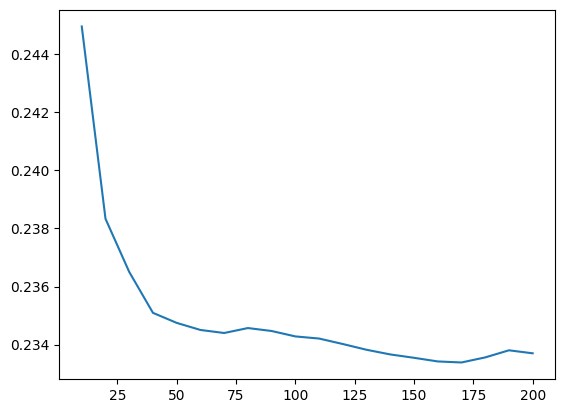

In [82]:
score_df = pd.DataFrame(scores,columns=["n_estimator","rmse"])
plt.plot(score_df.n_estimator,score_df.rmse)

In [83]:
min_val = 9999
min_list =[]
for depth in [10, 15, 20, 25]:
    for n_estimator in range(10,201,10):
        rf= RandomForestRegressor(n_estimators=n_estimator,max_depth=depth,random_state=1,n_jobs=-1)
        rf.fit(encoded_df_train,y_train)
        y_predict = rf.predict(encoded_df_val)
        rmse=mean_squared_error(y_val,y_predict,squared=False)
        if rmse< min_val:
            min_val = rmse
            min_list = [depth,n_estimator]

print(min_val,min_list)            

0.2333904823769441 [25, 170]


In [84]:
rf= RandomForestRegressor(n_estimators=10,max_depth=20,random_state=1,n_jobs=-1)
rf.fit(encoded_df_train,y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [88]:
feature_importance = rf.feature_importances_
feature_importance_dict = dict(zip(dv.get_feature_names_out(input_features=df_train.columns), feature_importance))
most_important_feature = max(feature_importance_dict, key=feature_importance_dict.get)
print("The most important feature is:", most_important_feature)

The most important feature is: median_income


In [106]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

<9411x10 sparse matrix of type '<class 'numpy.float64'>'
	with 84699 stored elements in Compressed Sparse Row format>

In [107]:
feature_names=list(dv.get_feature_names_out())
print(feature_names)
df_train_xgb = xgb.DMatrix(encoded_df_train,label=y_train,feature_names=feature_names)
df_val_xgb = xgb.DMatrix(encoded_df_val,label=y_val,feature_names=feature_names)

['households', 'housing_median_age', 'latitude', 'longitude', 'median_income', 'ocean_proximity=_1h_ocean', 'ocean_proximity=inland', 'population', 'total_bedrooms', 'total_rooms']


/home/peng/ML_Zoom_Camp/ML_Venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


In [108]:
xgb_model_3 = xgb.train(xgb_params,df_train_xgb,num_boost_round=20)

In [109]:
y_pred_3 =xgb_model_3.predict(df_val_xgb)
mean_squared_error(y_val,y_pred_3,squared=False)

0.24126545352123252

In [110]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [111]:
xgb_model_1 = xgb.train(xgb_params,df_train_xgb,num_boost_round=20)

In [112]:
y_pred_1 =xgb_model_1.predict(df_val_xgb)
mean_squared_error(y_val,y_pred_1,squared=False)

0.27123310561382014